## Prep

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# functions
def num_age(x):
    '''make age categories numeric'''
    if x == '18-39':
        return 0
    elif x == '40-44':
        return 1
    elif x == '45-49':
        return 2
    elif x == '50-54':
        return 3
    elif x == '55-59':
        return 4
    elif x == '60-64':
        return 5
    elif x == '65-69':
        return 6
    return 7


def cat_clean(x):
    '''binary columns were floats, make them ints'''
    return int(x)


def prep(df):
    '''prepare dataframe for EDA'''
    df['age'] = df['age'].apply(lambda x: num_age(x))
    df['clear'] = df['clear'].apply(lambda x: cat_clean(x))
    df['overcast'] = df['overcast'].apply(lambda x: cat_clean(x))
    df['partially_cloudy'] = df['partially_cloudy'].apply(lambda x: cat_clean(x))
    df['rain'] = df['rain'].apply(lambda x: cat_clean(x))

    cols = ['year', 'age', 'male', 'time_seconds', 'minimum_temperature',
           'maximum_temperature', 'temperature', 'relative_humidity', 'wind_speed',
           'precipitation', 'precipitation_cover', 'cloud_cover', 'clear',
           'overcast', 'partially_cloudy', 'rain']

    for col in cols:
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

    df.drop(columns=['maximum_temperature', 'minimum_temperature'], inplace=True)

    event_dict = {year: df[df['year'] == year] for year in df['year'].unique()}
    
    return event_dict


def usable(event_dict, num):
    '''specify which years are usable based on minimum number of participants
    returns dict with years that exceed minimum values are correspoding df'''
    can_use = []
    for year in event_dict.keys():
        if len(event_dict[year]) > num:
            can_use.append(year)
    return {year: event_dict[year] for year in can_use}


def top_n(event_dict, num):
    '''take in event dict and first num of finishers that are desired,
    return df of top n racers for all years, use in conjuction with usable()'''
    df = pd.DataFrame()
    for year in event_dict.keys():
        df = pd.concat([df, event_dict[year].sort_values(by='time_seconds').iloc[:num]], ignore_index=True)
    return df
        
    
def n_range(event_dict, low, high):
    '''take in dictionary of dfs from prep(), upper percentage as float, lower percentage as float
    return df'''
    df = pd.DataFrame()
    for year in event_dict.keys():
        df = pd.concat([df, event_dict[year].sort_values(by='time_seconds').iloc[int(len(event_dict[year]) * low): int(len(event_dict[year]) * high)]], ignore_index=True)
    return df

def model_scores(X_test, y_test, model):
    nl = "\n"
    y_preds = model.predict(X_test)
    return print(f'R2: {model.score(X_test, y_test)}{nl}MAE: {mean_absolute_error(y_test, y_preds)}{nl}MSE: {mean_squared_error(y_test, y_preds)}{nl}RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

def undo_age(x):
    '''make age categories their division again'''
    if x == 0.0:
        return '18-39'
    elif x == 1.0:
        return '40-44'
    elif x == 2.0:
        return '45-49'
    elif x == 3.0:
        return '50-54'
    elif x == 4.0:
        return '55-59'
    elif x == 5.0:
        return '60-64'
    elif x == 6.0:
        return '65-69'
    return '70+'

In [46]:
london = pd.read_csv('./data/London_Data/Clean/Clean_London_Results_Weather.csv')
nyc = pd.read_csv('./data/NYC_Data/Clean/Clean_NYC_Results_Weather.csv')
boston = pd.read_csv('./data/Boston_Data/Clean/Clean_Boston_Results_Weather.csv')
berlin = pd.read_csv('./data/Berlin_Data/Clean/Clean_Berlin_Results_Weather.csv')
chicago = pd.read_csv('./data/Chicago_Data/Clean/Clean_Chicago_Results_Weather.csv')

london_dict = prep(london)
nyc_dict = prep(nyc)
boston_dict = prep(boston)
berlin_dict = prep(berlin)
chicago_dict = prep(chicago)

london = n_range(usable(london_dict, 0), 0, 1)
nyc = n_range(usable(nyc_dict, 0), 0, 1)
boston = n_range(usable(boston_dict, 0), 0, 1)
berlin = n_range(usable(berlin_dict, 0), 0, 1)
chicago = n_range(usable(chicago_dict, 0), 0, 1)

events = [berlin, boston, chicago, london, nyc]
count = 0
for event in events:
    event['event'] = count
    count += 1
combined_i = pd.concat(events, ignore_index=True)

aggregate = {col: 'mean' for col in combined}

combined = combined_i.groupby(['year','event', 'age', 'male']).agg(aggregate)
combined['age'] = combined['age'].apply(lambda x: undo_age(x))

combined = combined[combined['year'] >= 2000]
combined = combined[combined['year'] < 2019]

combined['event'] = np.where(combined['event'] == 0, 'berlin', 
                            np.where(combined['event'] == 1, 'boston',
                                    np.where(combined['event'] == 2, 'chicago',
                                            np.where(combined['event'] == 3, 'london', 'nyc'))))
combined['male'] = np.where(combined['male'] == 0, 'female', 'male')


combined_i['age'] = combined_i['age'].apply(lambda x: undo_age(x))

combined_i = combined_i[combined_i['year'] >= 2000]
combined_i = combined_i[combined_i['year'] < 2019]

combined_i['event'] = np.where(combined_i['event'] == 0, 'berlin', 
                            np.where(combined_i['event'] == 1, 'boston',
                                    np.where(combined_i['event'] == 2, 'chicago',
                                            np.where(combined_i['event'] == 3, 'london', 'nyc'))))
combined_i['male'] = np.where(combined_i['male'] == 0, 'female', 'male')

## ---------

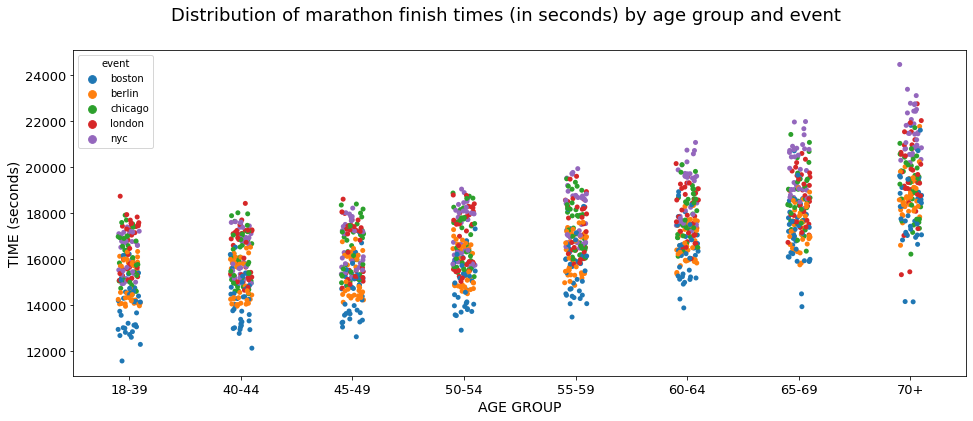

In [32]:
plt.figure(figsize=(16,6))
plt.suptitle("Distribution of marathon finish times (in seconds) by age group and event", fontsize=18)
sns.stripplot(x = 'age', 
            y = 'time_seconds', 
            hue='event',
            hue_order=['boston', 'berlin', 'chicago', 'london', 'nyc'],
            data=combined)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Age Group', fontsize=14);
plt.ylabel('Time (seconds)', fontsize=14);

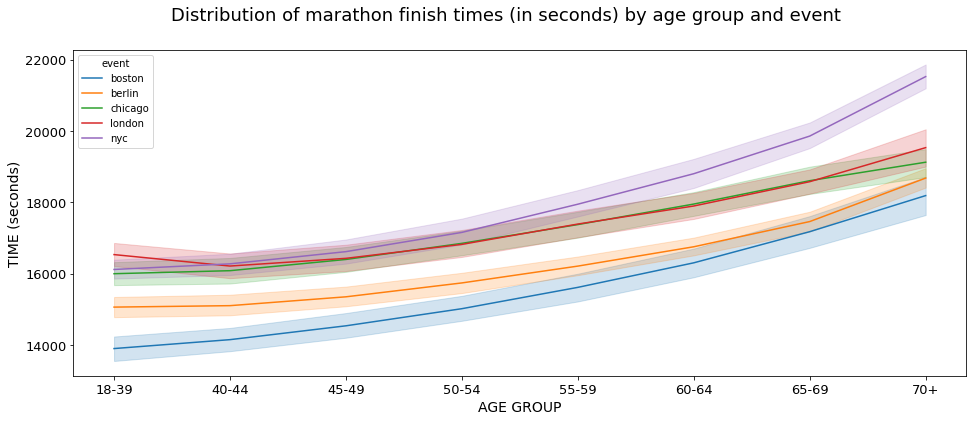

In [33]:
plt.figure(figsize=(16,6))
plt.suptitle("Distribution of marathon finish times (in seconds) by age group and event", fontsize=18)
sns.lineplot(x = 'age', 
            y = 'time_seconds', 
            hue='event',
            hue_order=['boston', 'berlin', 'chicago', 'london', 'nyc'],
            data=combined);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Age Group', fontsize=14);
plt.ylabel('Time (seconds)', fontsize=14);

In [64]:
plt.figure(figsize=(16,6))
plt.suptitle("Distribution of marathon finish times (in seconds) by age group and gender", fontsize=18)
sns.stripplot(x = 'age', 
            y = 'time_seconds', 
            hue='male',
            hue_order=['male', 'female'],
            data=combined_i)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Age Group', fontsize=14);
plt.ylabel('Time (seconds)', fontsize=14);

Error in callback <function flush_figures at 0x000001B1A574EC10> (for post_execute):


KeyboardInterrupt: 

In [104]:
temp = combined[combined['event'] == 'nyc'].groupby('relative_humidity').agg({'time_seconds': 'mean'})

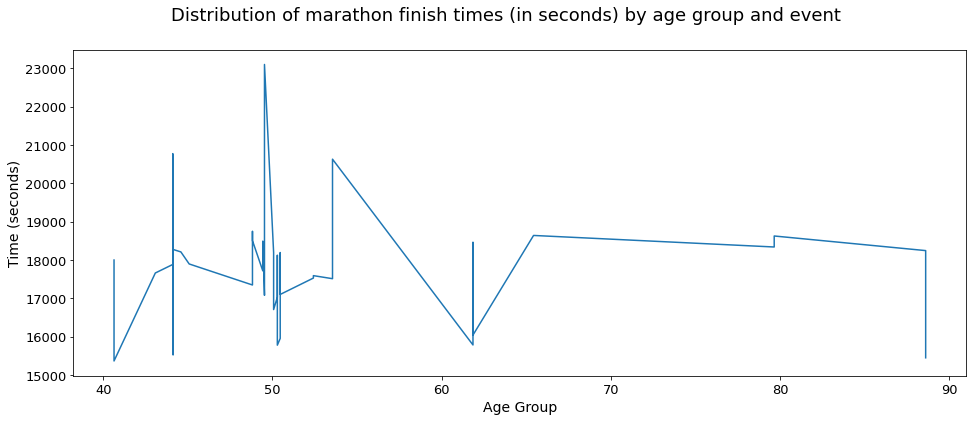

In [105]:
plt.figure(figsize=(16,6))
plt.suptitle("Distribution of marathon finish times (in seconds) by age group and event", fontsize=18)
plt.plot(temp.index, temp['time_seconds']);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Age Group', fontsize=14);
plt.ylabel('Time (seconds)', fontsize=14);